In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras import optimizers

# 导入数据
data = pd.read_csv('/content/tea_data.csv',encoding='utf-8')
#data=data.drop(['datetime'],axis=1)
data.head()
# 正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['土壤溫度'].values.reshape(-1,1))

# 產生訓練與測試
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# 创建适用于时间序列的数据结构
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# 将数据重塑为LSTM输入所需的三维格式 [样本数, 时间步长, 特征数]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Bi-LSTM模型
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(time_step, 1)))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
#model.compile(loss='categorical_crossentropy',optimizer=optimizers.SGD(learning_rate=0.001),metrics=['accuracy'])
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=40, batch_size=64, verbose=1)

# 測試預測
predictions = model.predict(X_test)

# 反歸化預測值和實際值
predictions = scaler.inverse_transform(predictions)
Y_test = scaler.inverse_transform([Y_test])

# 計算MSE and RMSE
mse = mean_squared_error(Y_test[0], predictions[:,0])
rmse = np.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
# 繪製結果
plt.rcParams["figure.figsize"] = (10, 6)
plt.scatter(predictions.flatten(),Y_test.flatten(), label='Actual Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Stock Soil Moisture')
plt.title('SoilHum using Bi-LSTM')
plt.legend()
plt.show()
plt.rcParams["figure.figsize"] = (10, 6)
plt.plot(Y_test.flatten(), label='Actual Soil Moisture')
plt.plot(predictions.flatten(), label='Predicted Soil Moisture',color="#d62728")
#plt.text(0, 10, 'Loss(MSE)=%.3f',mse,{'size': 15, 'color':  'red'})
plt.xlabel('Time')
plt.ylabel('Stock Soil Moisture')
plt.title('SoilHum using Bi-LSTM')
plt.legend()
plt.show()


Epoch 1/40
36/36 [==============================] - 21s 303ms/step - loss: 0.0299 - val_loss: 0.0088
Epoch 2/40
36/36 [==============================] - 7s 205ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 3/40
36/36 [==============================] - 9s 258ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 4/40
36/36 [==============================] - 10s 272ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 5/40
36/36 [==============================] - 7s 208ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 6/40
24/36 [===================>..........] - ETA: 3s - loss: 0.0028

KeyboardInterrupt: 

Train Score: 0.24 RMSE
Test Score: 0.30 RMSE


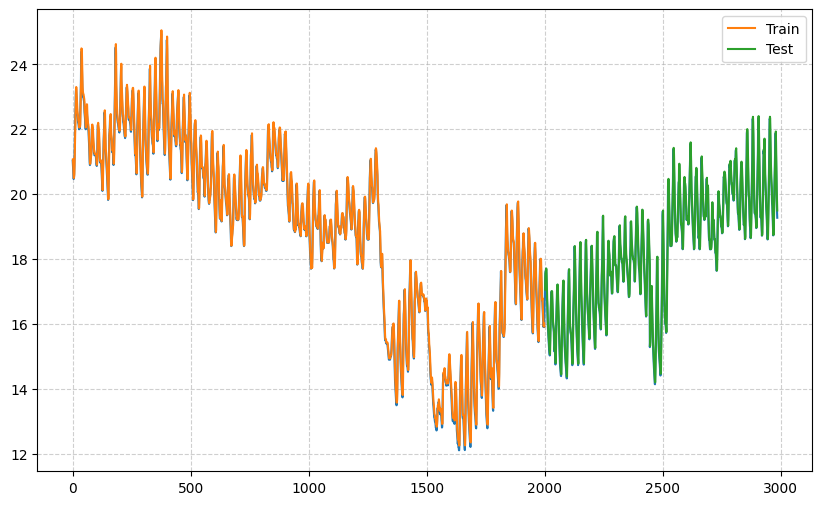

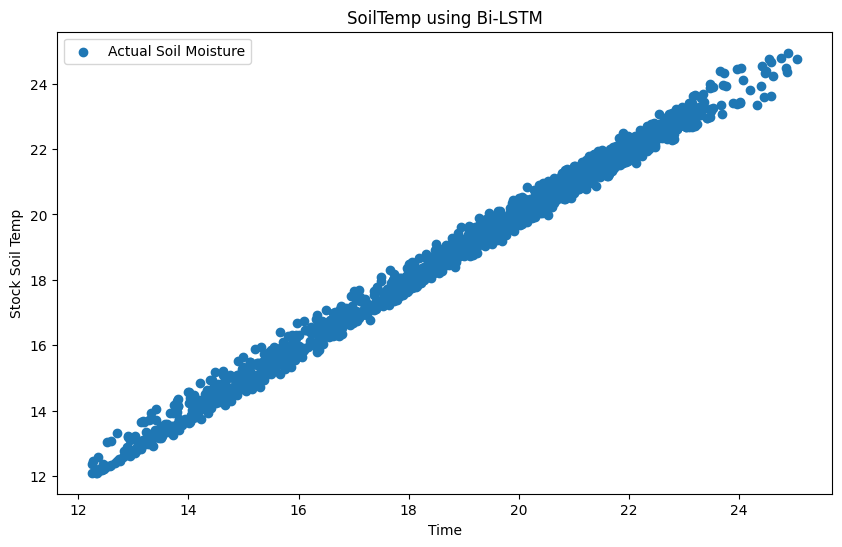

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from sklearn.metrics import mean_squared_error

# 导入数据
# 这里假设你已经有了股票数据，如CSV文件，其中包含了日期和股票价格
data = pd.read_csv('/content/tea_data.csv',encoding='utf-8')
# 数据预处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['土壤溫度'].values.reshape(-1,1))

# 划分数据集为训练集和测试集
train_size = int(len(scaled_data) * 0.67)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

# 创建适用于时间序列的数据结构
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 将数据重塑为LSTM输入所需的三维格式 [样本数, 时间步长, 特征数]
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

# 构建Bi-LSTM模型
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(look_back, 1)))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
# 训练模型
model.fit(trainX, trainY,validation_data=(testX, testY), epochs=40, batch_size=64, verbose=1)

# 对测试集进行预测
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# 反归一化预测值和实际值
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# 计算RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# 畫訓練資料趨勢圖
# shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled_data)-1, :] = testPredict

# 畫原始資料趨勢圖
# plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Test')
plt.grid(True,linestyle='--',alpha=0.6)
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(trainPredict.flatten(),trainY.flatten(), label='Actual Soil Moisture')
plt.xlabel('Time')
plt.ylabel('Stock Soil Temp')
plt.title('SoilTemp using Bi-LSTM')
plt.legend()
plt.show()